In [1]:
!pip install navigation-vis navigation-mdp

In [2]:
import numpy as np
# navigation mdp
from navigation_mdp.state import DiscreteStateSpace
from navigation_mdp.class_ import XYClassDistribution
from navigation_mdp.features import FeatureClassImageSampler
from navigation_mdp.reward import RewardStateScalar
from navigation_mdp.dynamics import XYDynamics

# navigation vis
from navigation_vis.Raster import Raster as NavGridView

import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Features

In [3]:
import torchvision
cifar = torchvision.datasets.CIFAR100(root="../datasets/", download=True)
X, y = cifar.data, np.asarray(cifar.targets)
classes = np.unique(y)
n_classes = len(classes)

print(X.shape, y.shape)

def sample_image(X, y, y_q):
    x_q = X[y == y_q]
    return x_q[np.random.randint(0, len(x_q))]

Files already downloaded and verified
(50000, 32, 32, 3) (50000,)


## Discrete State Space

In [4]:
np.random.seed(5)
# Specify state space
S = DiscreteStateSpace(5,5)

# Attach classes
S.attach_classes(
    
    XYClassDistribution([
        
        [0, 0, 0, 0, 0],
        [0, 1, 1, 1, 0],
        [0, 1, 1, 1, 0],
        [0, 1, 1, 1, 0],
        [0, 0, 0, 0, 0]],
        marker_to_class_id = {
            1: 76,
            0: 68
        },
    )().flatten()
)

# Attach features
S.attach_feature_spec(FeatureClassImageSampler(lambda x: sample_image(X, y, x)))

# For visualization
PHI_gridded = S.features(gridded=True)

# Attach rewards
goal = (4,4)
S.attach_reward_spec(RewardStateScalar(loc_to_reward_dict={goal: 1}, class_id_to_reward_dict={
    76: 0, 68: 0}, default=0))
R = S.rewards()

## Visualization

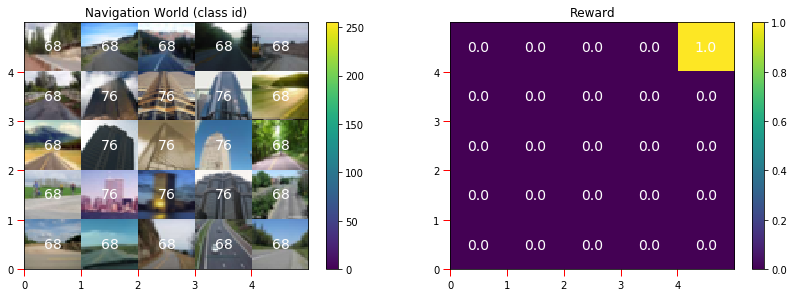

In [5]:
PHI_gridded_vis = np.flip(PHI_gridded, 2) # flip images vertically for cartesian system

fig = plt.figure(figsize=(14,10))
state_ann_sz = 14
state_ann_color = "white"
plt.subplot(2,2,1)
p = NavGridView(PHI_gridded_vis, ax=plt.gca()).render().ticks(minor=False).show_cell_text(
    S.class_ids, fontsize=state_ann_sz, color_cb=lambda x: state_ann_color).title("Navigation World (class id)")
plt.colorbar(p.im)
p.ax.invert_yaxis() # cartesian coordinates

plt.subplot(2,2,2)
p = NavGridView(R[..., np.newaxis, np.newaxis, np.newaxis], ax=plt.gca()).render().ticks(minor=False).show_cell_text(
    R, fontsize=state_ann_sz, color_cb=lambda x: state_ann_color).title("Reward")
plt.colorbar(p.im)
p.ax.invert_yaxis() # cartesian coordinates

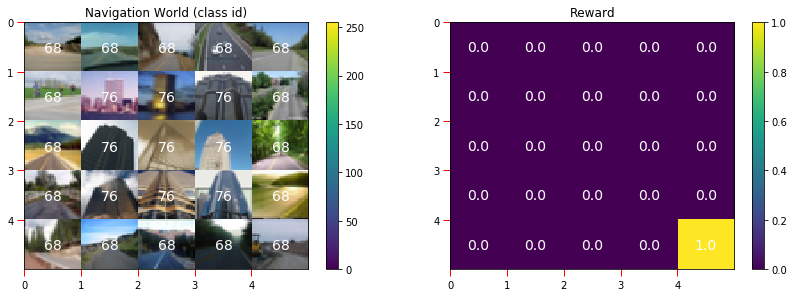

In [6]:
PHI_gridded_vis = PHI_gridded

fig = plt.figure(figsize=(14,10))
state_ann_sz = 14
state_ann_color = "white"
plt.subplot(2,2,1)
p = NavGridView(PHI_gridded_vis, ax=plt.gca()).render().ticks(minor=False).show_cell_text(
    S.class_ids, fontsize=state_ann_sz, color_cb=lambda x: state_ann_color).title("Navigation World (class id)")
plt.colorbar(p.im)

plt.subplot(2,2,2)
p = NavGridView(R[..., np.newaxis, np.newaxis, np.newaxis], ax=plt.gca()).render().ticks(minor=False).show_cell_text(
    R, fontsize=state_ann_sz, color_cb=lambda x: state_ann_color).title("Reward")
plt.colorbar(p.im)

## LfD World

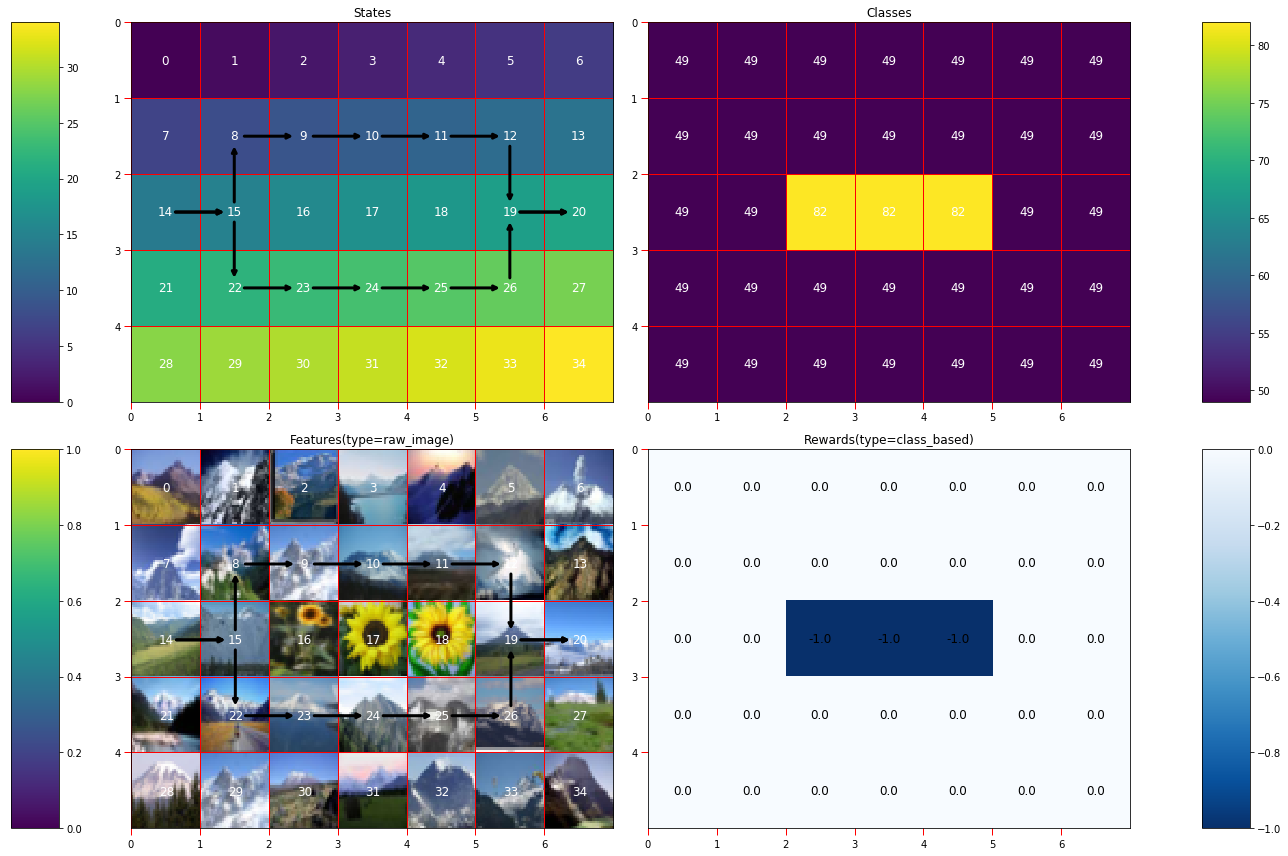

In [7]:
import navigation_mdp as NvMDP

s_lst_lst = [[(2,0), (2,1), (1,1), (1,2), (1,3), (1,4), (1,5), (2,5), (2,6)], 
            [(2,0), (2,1), (3,1), (3,2), (3,3), (3,4), (3,5), (2,5), (2,6)]]

phi_spec_cifar100_rgb = NvMDP.features.FeatureClassImageSampler(
    lambda x: sample_image(X, y, x) / 255., 
    key="raw_image")
r_spec_const = NvMDP.reward.RewardStateScalar(
    loc_to_reward_dict={(2,6): 0.}, 
    class_id_to_reward_dict={82: -1}, default=0, 
    key="class_based", feature_key=None)

lfdw = NvMDP.world.DiscreteLfDWorld2D(
            discrete_state_space = NvMDP.state.DiscreteStateSpace(5,7),
            class_ids = NvMDP.class_.XYClassDistribution([
                [0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0],
                [0, 0, 1, 1, 1, 0, 0],
                [0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0]], 
                marker_to_class_id = {0: 49, 1: 82})().flatten(),
            phi_spec = [phi_spec_cifar100_rgb],
            r_spec = [r_spec_const],
            s_lst_lst = s_lst_lst,
            a_lst_lst = None
        )
NvMDP.plotting.plot_irl_world(lfdw.S, lfdw.trajectories()[0], r_key="class_based", phi_key="raw_image")